In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import time
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

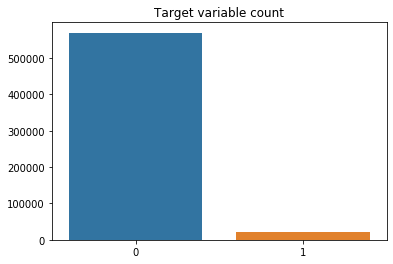

In [2]:
train_transaction = pd.read_csv('train_transaction.csv')
train_identity = pd.read_csv('train_identity.csv')
x=train_transaction['isFraud'].value_counts().values
sns.barplot([0,1],x)
plt.title('Target variable count')
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

In [3]:
def reduce_mem_usage2(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


train = reduce_mem_usage2(train)

Memory usage of dataframe is 1959.88 MB
Memory usage after optimization is: 530.08 MB
Decreased by 73.0%


In [3]:
x=train.drop('isFraud',axis=1)
y=np.ravel(train['isFraud'])


Drop the columns with null or NAN valuse over 90%

In [4]:

one_value_cols = [col for col in x.columns if x[col].nunique() <= 1]
print(f'There are {len(one_value_cols)} columns in train dataset with one unique value.')
many_null_cols = [col for col in x.columns if x[col].isnull().sum() / x.shape[0] > 0.9]
big_top_value_cols = [col for col in x.columns if x[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
cols_drop = list(set(many_null_cols + big_top_value_cols))
print(cols_drop)
print(len(cols_drop))

x=x.drop(cols_drop,axis=1)


There are 0 columns in train dataset with one unique value.
['V116', 'V296', 'V120', 'V125', 'V319', 'D7', 'V107', 'V119', 'V105', 'V117', 'V121', 'V290', 'V297', 'id_07', 'V318', 'id_23', 'V136', 'V134', 'V103', 'V98', 'id_08', 'V309', 'V295', 'V321', 'id_21', 'V284', 'id_22', 'V118', 'V298', 'V132', 'V281', 'id_25', 'V109', 'V115', 'V305', 'V111', 'V293', 'id_26', 'dist2', 'V104', 'id_18', 'V123', 'V102', 'V133', 'V301', 'V137', 'id_27', 'V108', 'C3', 'V113', 'V122', 'V106', 'V124', 'V311', 'V316', 'id_24', 'V110', 'V112', 'V299', 'V129', 'V135', 'V300', 'V320', 'V114', 'V101', 'V286']
66


In [5]:
cat_cols = ['ProductCD', 'card1','card2','card3','card4','card5','card6','addr1','addr2','P_emaildomain','R_emaildomain','M1','M2','M3','M4','M5','M6','M7','M8','M9','id_12','id_13','id_14','id_15','id_16','id_17','id_19','id_20','id_28','id_29','id_30','id_31','id_32','id_33','id_34','id_35','id_36','id_37','id_38','DeviceType','DeviceInfo']
for col in cat_cols:
    if col in x.columns:
        le = LabelEncoder()
        le.fit(list(x[col].astype(str).values))
        x[col] = le.transform(list(x[col].astype(str).values))

In [6]:
features = np.ravel(x.columns)
num_cols=np.setdiff1d(features,cat_cols)
SS=StandardScaler()
x[num_cols]=SS.fit_transform(x[num_cols])

In [7]:
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)   

# Cleaning infinite values to NaN
x = clean_inf_nan(x)

In [8]:
from sklearn.impute import SimpleImputer
imp=SimpleImputer()
imputed_x=imp.fit_transform(x)
x_new=pd.DataFrame(imputed_x)
x_new.columns=x.columns

Ranking of features

In [11]:
#only use the first 47 features
cols_for_model=['V258','C1','card1','card2','addr1','TransactionID','TransactionDT','TransactionAmt','C14','C13','id_31','id_20','id_19','id_05','id_02','id_01','dist1','card6','card5','card3','V87','V62','V45','V317','V315','V313','V310','V307','V283','V189','V156','P_emaildomain','DeviceInfo','D8','D5','D4','D2','D15','D11','D10','D1','C9','C8','C6','C2','C12','C11']
x_n=x_new[cols_for_model]
#lr
X_train1, X_test1, y_train1, y_test1 = train_test_split(x_n,y, test_size=0.2, random_state=42)
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train1,y_train1, test_size=0.2, random_state=42)
#lr=LogisticRegression()
#lr.fit(X_train2,y_train2)
#y_pred0=lr.predict(X_val2)
#print(roc_auc_score(y_val2,y_pred0))

PCA

In [11]:
from sklearn import decomposition
pca = decomposition.PCA(n_components = 10)
data_all=pd.concat([x_n,pd.DataFrame(y)],axis=1)

In [12]:
pca.fit(x_n)
x_transformed = pca.transform(x_n)
x_transformed_df = pd.DataFrame(x_transformed)

pca_RF LR KNN

In [13]:
X_train_pca1, X_test_pca, y_train_pca1, y_test_pca = train_test_split(x_transformed,y, test_size=0.2, random_state=42)
X_train_pca, X_val_pca, y_train_pca, y_val_pca = train_test_split(X_train_pca1,y_train_pca1, test_size=0.2, random_state=42)

In [40]:
rf1=RandomForestClassifier(random_state=42)
rf1.fit(X_train_pca,y_train_pca)
y_pred1=rf1.predict(X_val_pca)
print(roc_auc_score(y_val_pca,y_pred1))

lr1=LogisticRegression()
lr1.fit(X_train_pca,y_train_pca)
y_pred2=lr1.predict(X_val_pca)
print(roc_auc_score(y_val_pca,y_pred2))

from sklearn.neighbors import KNeighborsClassifier
md1 = KNeighborsClassifier(n_neighbors = 2)
md1.fit(X_train_pca,y_train_pca)
y_pred3=md1.predict(X_val_pca)
print(roc_auc_score(y_val_pca,y_pred3))

0.7526857408576785


D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.5486212277649013
0.7106698407505152


Up-sampling

In [41]:
y_train_up=pd.DataFrame(y_train_pca)
y_train_up.columns=['isFraud']
X_train_up=pd.DataFrame(X_train_pca)
data_all=pd.concat([X_train_up,y_train_up],axis=1)
not_fraud=data_all[data_all.isFraud==0]
fraud=data_all[data_all.isFraud==1]

fraud_upsampled=resample(fraud,replace=True,n_samples=len(not_fraud),random_state=27)
new_data=pd.concat([not_fraud,fraud_upsampled])
new_data.isFraud.value_counts()
x_train_1=new_data.drop('isFraud',axis=1)
y_train_1=np.ravel(new_data['isFraud'])
rf2=RandomForestClassifier(random_state=0)

#x_train_1=imp.fit_transform(x_train_1)
#x_train_1_df=pd.DataFrame(x_train_1)

rf2.fit(x_train_1,y_train_1)
y_pred4=rf2.predict(X_val_pca)
print(roc_auc_score(y_val_pca,y_pred4))


#knn lr
lr2=LogisticRegression()
lr2.fit(x_train_1,y_train_1)
y_pred5=lr2.predict(X_val_pca)
print(roc_auc_score(y_val_pca,y_pred5))

md2 = KNeighborsClassifier(n_neighbors = 2)
md2.fit(x_train_1,y_train_1)
y_pred6=md2.predict(X_val_pca)
print(roc_auc_score(y_val_pca,y_pred6))


0.7796493154556405


D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.6600975559419774
0.7997233545918383


Down-sampling

In [19]:
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = len(fraud), # match minority n
                                random_state = 27)
new_data1=pd.concat([not_fraud_downsampled,fraud])
new_data1.isFraud.value_counts()

1    13028
0    13028
Name: isFraud, dtype: int64

In [20]:
x_train_2=new_data1.drop('isFraud',axis=1)
y_train_2=np.ravel(new_data1['isFraud'])
#x_train_2=imp.fit_transform(x_train_2)
#x_train_2_df=pd.DataFrame(x_train_2)

rf3=RandomForestClassifier(random_state=0)
rf3.fit(x_train_2,y_train_2)
y_pred7=rf3.predict(X_val_pca)
print(roc_auc_score(y_val_pca,y_pred7))

#knn lr
lr3=LogisticRegression()
lr3.fit(x_train_2,y_train_2)
y_pred8=lr3.predict(X_val_pca)
print(roc_auc_score(y_val_pca,y_pred8))

md3 = KNeighborsClassifier(n_neighbors = 2)
md3.fit(x_train_2,y_train_2)
y_pred9=md3.predict(X_val_pca)
print(roc_auc_score(y_val_pca,y_pred9))

0.8107172158896296
0.6550595359595612
0.7659833359012608


SMOTE

In [22]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(random_state=42)
x_sm1,y_sm1 = smote.fit_sample(X_train_up,np.ravel(y_train_up))
print("length of oversampled data is ",len(x_sm1))
print("Number of no subscription in oversampled data",len(y_sm1[y_sm1==0]))

#RFC
rf4=RandomForestClassifier(random_state=0)
rf4.fit(x_sm1,y_sm1)
y_pred10=rf4.predict(X_val_pca)
print(roc_auc_score(y_val_pca,y_pred10))

#LR KNN
lr4=LogisticRegression()
lr4.fit(x_sm1,y_sm1)
y_pred11=lr4.predict(X_val_pca)
print(roc_auc_score(y_val_pca,y_pred11))

md4 = KNeighborsClassifier(n_neighbors = 2)
md4.fit(x_sm1,y_sm1)
y_pred12=md4.predict(X_val_pca)
print(roc_auc_score(y_val_pca,y_pred12))

length of oversampled data is  729834
Number of no subscription in oversampled data 364917
0.8045197655060677
0.651792581916675
0.7750699036309278


In [9]:
import xgboost as xgb
from xgboost import XGBClassifier

In [54]:
alg =XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                        min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                        objective='binary:logistic', nthread=4, scale_pos_weight=10, seed=27)



In [55]:
cv_folds=5
early_stopping_rounds=50
print("Start Feeding Data")
xgb_param = alg.get_xgb_params()
xgtrain = xgb.DMatrix(X_train2.values, label=(pd.DataFrame(y_train2)).values)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                  early_stopping_rounds=early_stopping_rounds)
alg.set_params(n_estimators=cvresult.shape[0])

    
print('Start Training')
alg.fit(X_train2, (pd.DataFrame(y_train2)), eval_metric='auc')

    
print("Start Predicting")
predictions = alg.predict(X_val2)
pred_proba = alg.predict_proba(X_val2)[:, 1]
print("AUC of validation dataset: %f" % roc_auc_score((pd.DataFrame(y_val2)), pred_proba))



Start Feeding Data
Start Training


D:\anaconda\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Start Predicting
AUC of validation dataset: 0.917093


In [56]:
y_pred0=alg.predict(X_test1)
pred0_proba = alg.predict_proba(X_test1)[:, 1]
print("AUC of test dataset:")
print( roc_auc_score(pd.DataFrame(y_test1), pred0_proba))

AUC of test dataset:
0.91879422020605


XGboost

In [28]:
#test

def xgb_classifier(X_train, X_test, y_train, y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train,y_train, test_size=0.2, random_state=42)
    
    alg = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                        min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                        objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

    if useTrainCV:
        print("Start Feeding Data")
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train2.values, label=y_train2.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])

    
    print('Start Training')
    alg.fit(X_train2, y_train2, eval_metric='auc')

    
    print("Start Predicting")
    predictions = alg.predict(X_val2)
    pred_proba = alg.predict_proba(X_val2)[:, 1]

    
   
    print("AUC of validation dataset: %f" % roc_auc_score(y_val2, pred_proba))
    y_pred0=alg.predict(X_test)
    pred0_proba = alg.predict_proba(X_test)[:, 1]
    print("AUC of test dataset:")
    print( roc_auc_score(y_test, pred0_proba))

    feat_imp = alg.feature_importances_
    feat = X_train.columns.tolist()
    
    res_df = pd.DataFrame({'Features': feat, 'Importance': feat_imp}).sort_values(by='Importance', ascending=False)
    res_df.plot('Features', 'Importance', kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.savefig('xgb.pdf', bbox_inches='tight')
    plt.show()
    print(res_df)
    print(res_df["Features"].tolist())


Start Feeding Data
Start Training


D:\anaconda\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Start Predicting
AUC of validation dataset: 0.910413
AUC of test dataset:
0.9128949944496245


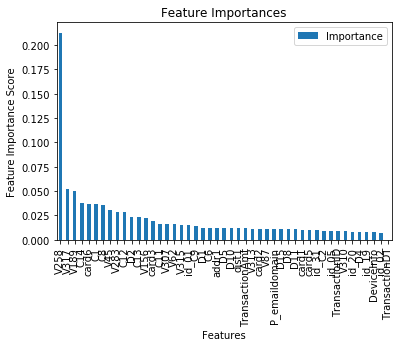

          Features  Importance
0             V258    0.212779
23            V317    0.052126
29            V189    0.050291
8              C14    0.038147
17           card6    0.037142
1               C1    0.036544
42              C8    0.035713
22             V45    0.030495
28            V283    0.028614
45             C12    0.028352
36              D2    0.023097
9              C13    0.023016
30            V156    0.022862
19           card3    0.019318
46             C11    0.016621
27            V307    0.016463
21             V62    0.015999
24            V315    0.015645
15           id_01    0.015051
41              C9    0.014525
40              D1    0.012625
43              C6    0.012607
4            addr1    0.012594
34              D5    0.012327
39             D10    0.012190
16           dist1    0.011996
7   TransactionAmt    0.011639
25            V313    0.011346
3            card2    0.011299
20             V87    0.010891
31   P_emaildomain    0.010748
37      

In [29]:
xgb_classifier(X_train1, X_test1, pd.DataFrame(y_train1), pd.DataFrame(y_test1))
